In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm


from model import AlexNet, LeNet, JustinNet

In [2]:
## Test learning to reweight model
# from main import Reweighting


# torch.backends.cudnn.enabled = False
# torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device = ", device)

class Reweighting():
    def __init__(self, network, hyperparameters, criterion, criterion_mean, optimizer, train_loader, valid_loader, test_loader):
        self.network = network.requires_grad_(requires_grad=True)
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.criterion_mean = criterion_mean
        self.gradient_network = None
    
    def paper_train(self):
        # X_g = LeNet5()
        # print("Starting training...")
        X_g, y_g = next(iter(self.valid_loader))
        X_g = X_g.to(device)
        y_g = y_g.to(device)

        y_f_hat = torch.empty(1)
        y_f_hat = y_f_hat.to(device)

        theta_tp1 = self.network.state_dict()
        for epoch in range(self.hyperparameters['n_epochs']):
            self.network.train()

            self.gradient_network = AlexNet()
            # self.gradient_network = LeNet()
            self.gradient_network.load_state_dict(theta_tp1)

            # get batch of data from train_loader
            X_f, y_f = next(iter(self.train_loader))
            X_f = X_f.to(device)
            y_f = y_f.to(device)

            # Line 4
            y_f_hat = self.gradient_network(X_f)
            
            # Line 5
            epsilon = torch.zeros(y_f.size(), requires_grad=True)
            epsilon = epsilon.to(device)

            Costs = self.criterion(y_f_hat, y_f.float())
            l_f = torch.sum(torch.mul(Costs, epsilon))

            # Line 6
            grad_t = torch.autograd.grad(outputs=l_f, inputs=self.gradient_network.params(), create_graph=True)
            

            # Line 7: manually update the weights of the validation network
            lr = self.hyperparameters['learning_rate']
            self.gradient_network.update_params_SGD_step(lr, grad_t)

            # Line 8
            # Model has theta_hat
            y_g_hat = self.gradient_network(X_g)

            # Line 9
            l_g = self.criterion_mean(y_g_hat, y_g.float())

            # Line 10
            grad_epsilon = torch.autograd.grad(l_g, epsilon, only_inputs=True)[0]

            # Line 11
            w_tilde = torch.clamp(-grad_epsilon, min=0)

            if torch.sum(w_tilde) != 0:
                w = w_tilde / torch.sum(w_tilde)
            else:
                w = w_tilde

            # Line 12
            y_f_hat = self.network(X_f)
            Costs = self.criterion(y_f_hat, y_f.float())
            l_f_hat = torch.sum(torch.mul(Costs, w))

            self.optimizer.zero_grad()

            # Line 13
            l_f_hat.backward()

            # Line 14
            self.optimizer.step()
            # break

            theta_tp1 = self.network.state_dict()

            if (epoch % self.hyperparameters['log_interval'] == 0):
                curr_accuracy = self.test()
                print("Epoch " + str(epoch) + " accuracy = ", curr_accuracy, " loss = ", l_f_hat.item())

    def train(self):
        # Train the network
        for epoch in range(self.hyperparameters['n_epochs']):
            self.network.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data = data.to(device)
                target = target.to(device)

                self.optimizer.zero_grad()
                output = self.network(data)
                # print(output)
                # print(target.float())
                loss = self.criterion_mean(output, target.float())
                # print(loss)
                loss.backward()
                self.optimizer.step()
                if batch_idx % self.hyperparameters['log_interval'] == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(self.train_loader.dataset),
                        100. * batch_idx / len(self.train_loader), loss.item()))
            
            if (epoch % self.hyperparameters['log_interval'] == 0):
                curr_accuracy = self.test()
                print("Epoch " + str(epoch) + " accuracy = ", curr_accuracy)


    def test(self):
        self.network.eval()

        acc = np.array([])
        for itr,(test_img, test_label) in enumerate(self.test_loader):
            prediction = self.network(test_img.to(device)).detach().cpu()
            # print(prediction)
            prediction = (torch.sigmoid(prediction) > 0.5).int().numpy()
            tmp = (prediction == test_label.detach().numpy())
            print(prediction)
            # print(test_label)
            # print(tmp)
            # acc.append(tmp)
            acc = np.append(acc,tmp)

        # print(acc)
        accuracy = np.mean(acc)
        return np.round(accuracy*100,2)


device =  cuda:0


In [3]:
# train_folder = '../dataset-ninja/train_unbiased'
# test_folder = '../dataset-ninja/test_unbiased'
# validate_folder = '../dataset-ninja/validate_unbiased'
train_folder = '../dataset-ninja/train_binary'
test_folder = '../dataset-ninja/test_binary'
validate_folder = '../dataset-ninja/validate_binary'

class_weights = [0.987, 0.013]  # Example weights for each class

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[107.96332894557823, 108.8669668707483, 116.74490789115646], std=[55.43744379373414, 59.496382526025215, 62.06132599239535]),  # Normalize images
])
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert images to PyTorch tensors
# ])

train_dataset = datasets.ImageFolder(train_folder, transform=transform)
weights = [class_weights[label] for label in train_dataset.targets]
train_sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

test_dataset = datasets.ImageFolder(test_folder, transform=transform)

validate_dataset = datasets.ImageFolder(validate_folder, transform=transform)


# number of epoch and log interval reduced for testing
hyperparameters = {
    'n_epochs' : 10000,
    'batch_size' : 2,
    'learning_rate' : 1e-3,
    'momentum' : 0.5,
    'log_interval' : 5
}

# network = AlexNet()
# network = LeNet()
network = JustinNet()

# criterion = nn.CrossEntropyLoss(reduction='none')
# criterion_mean = nn.CrossEntropyLoss(reduction='mean')
criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_mean = nn.BCEWithLogitsLoss(reduction='mean')

optimizer = optim.SGD(network.params(),
                        lr=hyperparameters['learning_rate'],
                        momentum=hyperparameters['momentum'])

# Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], sampler=train_sampler)
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(validate_dataset, batch_size=100, shuffle=True)

our_model = Reweighting(network, hyperparameters, criterion, criterion_mean, optimizer, train_loader, valid_loader, test_loader)

start_accuracy = our_model.test()
print("Starting accuracy = ", start_accuracy)

our_model.train()
# our_model.paper_train()

end_accuracy = our_model.test()
print("Ending accuracy = ", end_accuracy)



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Starting accuracy =  50.0
Train Epoch: 0 [0/6493 (0%)]	Loss: 0.693147
Train Epoch: 0 [10/6493 (0%)]	Loss: 0.693147
Train Epoch: 0 [20/6493 (0%)]	Loss: 0.693147
Train Epoch: 0 [30/6493 (0%)]	Loss: 0.693147
Train Epoch: 0 [40/6493 (1%)]	Loss: 0.693147
Train Epoch: 0 [50/6493 (1%)]	Loss: 0.693147
Train Epoch: 0 [60/6493 (1%)]	Loss: 0.693147
Train Epoch: 0 [70/6493 (1%)]	Loss: 0.693147
Train Epoch: 0 [80/6493 (1%)]	Loss: 0.693147
Train Epoch: 0 [90/6493 (1%)]	Loss: 0.693147
Train Epoch: 0 [100/6493 (2%)]	Loss: 0.693147
Train Epoch: 0 [110/6493 (2%)]	Loss: 0.693147
Train Epoch: 0 [120/6493 

KeyboardInterrupt: 

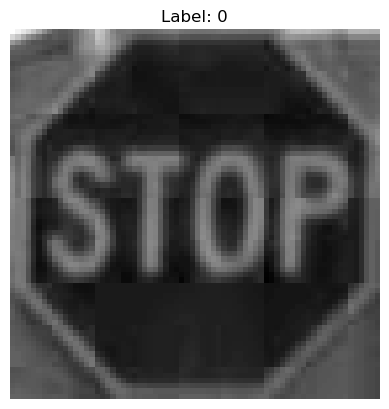

In [44]:
def show_images(dataloader, num_images):
    for batch_idx, (data, target) in enumerate(dataloader):
        for i in range(len(data)):
            plt.imshow(data[i][2,:,:].squeeze(), cmap='gray')
            plt.title(f"Label: {target[i]}")
            plt.axis('off')
            plt.show()

            num_images -= 1
            if num_images == 0:
                return

show_images(valid_loader, 1)

In [54]:
end_accuracy = our_model.test()
print("Ending accuracy = ", end_accuracy)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Ending accuracy =  50.0


In [7]:
our_model.network.eval()

acc = []
for itr,(test_img, test_label) in tqdm(enumerate(our_model.test_loader)):
    prediction = our_model.network(test_img.to(device)).detach().cpu().numpy()
    # print(prediction)
    prediction = np.argmax(prediction, axis=1)
    tmp = (prediction == test_label.detach().numpy())
    print(prediction)
    print(test_label)
    acc.append(tmp)

accuracy = np.concatenate(acc).mean()
end_accuracy = np.round(accuracy*100,2)

print("Ending accuracy = ", end_accuracy)

1it [00:01,  1.42s/it]

[2 2 2 ... 2 2 2]
tensor([7, 2, 2,  ..., 2, 2, 7])


2it [00:02,  1.32s/it]

[2 2 2 ... 2 2 2]
tensor([7, 2, 2,  ..., 7, 7, 2])


3it [00:03,  1.27s/it]

[2 2 2 ... 2 2 2]
tensor([2, 2, 7,  ..., 2, 2, 1])


4it [00:05,  1.23s/it]

[2 2 2 ... 2 2 2]
tensor([6, 2, 2,  ..., 2, 7, 7])


5it [00:06,  1.24s/it]

[2 2 2 ... 2 2 2]
tensor([7, 2, 7,  ..., 4, 7, 2])


6it [00:07,  1.21s/it]

[2 2 2 ... 2 2 2]
tensor([2, 2, 2,  ..., 2, 2, 2])


7it [00:08,  1.20s/it]

[2 2 2 ... 2 2 2]
tensor([7, 2, 4,  ..., 2, 7, 4])


8it [00:09,  1.18s/it]

[2 2 2 ... 2 2 2]
tensor([7, 2, 2,  ..., 6, 2, 2])


9it [00:10,  1.18s/it]

[2 2 2 ... 2 2 2]
tensor([7, 2, 2,  ..., 7, 2, 2])


10it [00:12,  1.17s/it]

[2 2 2 ... 2 2 2]
tensor([7, 2, 2,  ..., 2, 2, 0])


11it [00:13,  1.17s/it]

[2 2 2 ... 2 2 2]
tensor([2, 2, 2,  ..., 2, 2, 2])


12it [00:14,  1.17s/it]

[2 2 2 ... 2 2 2]
tensor([4, 2, 2,  ..., 4, 2, 2])


13it [00:15,  1.19s/it]

[2 2 2 ... 2 2 2]
tensor([2, 2, 2,  ..., 2, 2, 6])


14it [00:16,  1.18s/it]

[2 2 2 ... 2 2 2]
tensor([2, 7, 7,  ..., 2, 2, 2])


15it [00:18,  1.19s/it]

[2 2 2 ... 2 2 2]
tensor([2, 2, 7,  ..., 2, 7, 2])


16it [00:19,  1.21s/it]

[2 2 2 ... 2 2 2]
tensor([2, 2, 4,  ..., 4, 2, 2])


17it [00:20,  1.23s/it]

[2 2 2 ... 2 2 2]
tensor([4, 7, 2,  ..., 6, 7, 2])


18it [00:21,  1.23s/it]

[2 2 2 ... 2 2 2]
tensor([2, 6, 7,  ..., 2, 1, 2])


19it [00:22,  1.20s/it]

[2 2 2 ... 2 2 2]
tensor([7, 2, 6,  ..., 2, 4, 7])


20it [00:24,  1.19s/it]

[2 2 2 ... 2 2 2]
tensor([2, 2, 2,  ..., 7, 2, 7])


21it [00:25,  1.18s/it]

[2 2 2 ... 2 2 2]
tensor([7, 6, 2,  ..., 2, 7, 2])


22it [00:26,  1.15s/it]

[2 2 2 ... 2 2 2]
tensor([7, 2, 2,  ..., 2, 2, 2])


23it [00:27,  1.15s/it]

[2 2 2 ... 2 2 2]
tensor([2, 2, 7,  ..., 6, 2, 4])


24it [00:27,  1.16s/it]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2]
tensor([2, 2, 2, 6, 7, 2, 7, 6, 2, 2, 2, 2, 7, 1, 7, 2, 4, 2, 2, 2, 7, 7, 2, 7,
        2, 7, 7, 4, 2, 7, 2, 7, 2, 2, 2, 4, 7, 7, 2, 6, 6, 7, 2, 2, 7, 2, 2, 7,
        6, 2, 2, 2, 7, 7, 7, 7, 7, 1, 6, 2, 2, 2, 2, 4, 2, 7, 2, 7, 7, 7, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 7, 2, 2, 6, 2, 2, 2, 2, 2, 7, 2, 7, 2, 2, 7, 2, 2,
        2, 2, 2, 7, 2, 2, 2, 7, 4, 7, 2, 7, 2, 7, 7, 2